In [13]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load the CSV files
train_data_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\19X400X150_patch512_coordinates\landmark_1_coordinates.csv')

# Combine the dataframes
df = train_data_df
# Adjust the splitting ratios
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Split the dataframe into train, test, and validation sets
train_df, test_val_df = train_test_split(df, test_size=(test_ratio + val_ratio), random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=val_ratio/(test_ratio + val_ratio), random_state=42)

# Print the number of data points in each set
print("Number of data points in train set:", len(train_df))
print("Number of data points in validation set:", len(val_df))
print("Number of data points in test set:", len(test_df))

# Data augmentation configuration
# Data augmentation configuration
data_gen_args = {
    'rescale': 0.004,  # Rescale with a factor of 0.004
    'horizontal_flip': True,  # Horizontal flipping
    'vertical_flip': False,  # Vertical flipping is not included
    'zoom_range': 0.2,  # Zooming in and out by a factor of 2
    'shear_range': 2.0,  # Random shearing with a factor of 2
    'rotation_range': 0,  # Rotation is not included
    'fill_mode': 'nearest'
}


# ImageDataGenerator for training
train_datagen = ImageDataGenerator(**data_gen_args)

# ImageDataGenerator for testing/validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch512\landmark_1',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=64,
    shuffle=True
)

# Generator for validation data
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch512\landmark_1',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

# Generator for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch512\landmark_1',
    x_col='patch_filename',
    y_col=['x', 'y'],
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

# Save test data to CSV
test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\CephaXnet_My512_L1.csv', index=False)


Number of data points in train set: 41999
Number of data points in validation set: 6001
Number of data points in test set: 12000
Found 41999 validated image filenames.
Found 6001 validated image filenames.
Found 12000 validated image filenames.


In [14]:
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Reshape, Multiply, Add, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Adjust dropout rate
dropout_rate = 0.3

# Define the Squeeze-and-Excitation Block
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    x = Multiply()([init, se])
    return x

# Define the CNM Layer
def cnm_layer(input_tensor, filters, kernel_size=(3,3), pool_size=(2,2)):
    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size)(x)
    return x

# Input layer
input_layer = Input(shape=(256, 256, 1))  # You may need to adjust the input shape

# First CNM Layer
cnml1 = cnm_layer(input_layer, 32)
cnml1 = cnm_layer(cnml1, 64)

# Squeeze-and-Excitation Block
seb = squeeze_excite_block(cnml1)

# Skip Connection with element-wise summation
skip_connection = Add()([cnml1, seb])

# Second CNM Layer with skip connection as input
cnml2 = cnm_layer(skip_connection, 128)
cnml2 = cnm_layer(cnml2, 256)

# Flatten and Dense layers for regression
flatten = Flatten()(cnml2)
dropout = Dropout(dropout_rate)(flatten)  # Adjusted dropout rate
dense = Dense(512, activation='relu')(dropout)
dropout = Dropout(dropout_rate)(dense)  # Adjusted dropout rate
dense = Dense(256, activation='relu')(dropout)

# Output layer for regression
output_regression = Dense(2, activation='relu')(dense)  # Assuming 19 landmarks to predict

# Create the model
model = Model(inputs=input_layer, outputs=output_regression)

# Define optimizer without the decay argument
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)  

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using mean squared error for regression

# Model Summary
model.summary()



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 256, 256,  │          0 │ conv2d_16[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ re_lu_16[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 128, 128,  │          0 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_17… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1, 1, 4)   │        260 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1, 1, 64)  │        320 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 64, 64,    │          0 │ max_pooling2d_17… │
│ (Multiply)          │ 64)               │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 64,    │          0 │ max_pooling2d_17… │
│                     │ 64)               │            │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     73,856 │ add_4[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 32, 32,    │          0 │ re_lu_18[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_18… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 32, 32,    │          0 │ conv2d_19[0][0] 

 Total params: 34,075,206 (129.99 MB)

 Trainable params: 34,075,206 (129.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 930s 1s/step - loss: 8598.0166 - val_loss: 3708.6570
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1013s 2s/step - loss: 3866.5740 - val_loss: 3772.9666
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1029s 2s/step - loss: 2517.4580 - val_loss: 2626.1423
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1032s 2s/step - loss: 1969.5767 - val_loss: 5027.1626
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 1025s 2s/step - loss: 1616.9214 - val_loss: 5457.7329
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 960s 1s/step - loss: 1457.7720 - val_loss: 4501.0322
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - loss: 1221.9226 - val_loss: 5534.1025
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - loss: 1047.0563 - val_loss: 5940.2075
Epoch 9/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 818s 1s/step - loss: 1031.0002 - val_loss: 6279.0142
Epoch 10/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 767s 1s/step - loss: 860.1598 - val_loss: 6161.1318
Total training time: 9162.96 seconds


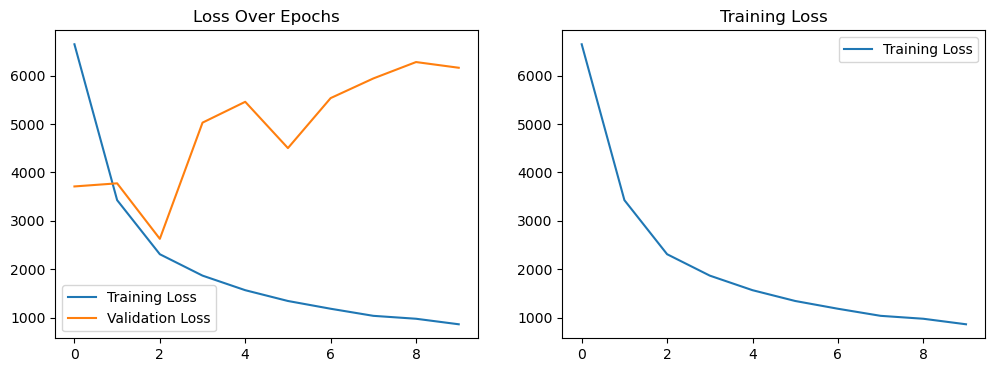

In [16]:
import time
import matplotlib.pyplot as plt

# Start training
start_time = time.time()

history = model.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1  # Added verbose argument to provide training progress
)

# End time
end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")

# Plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [7]:

# Save the trained model to a specific directory
#model.save(r'C:\Users\Student\Desktop\Shalu\CephaNet__L1.h5')


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\CephaXnet_My512_L1.csv',)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\19X400X150_random_patch512\landmark_1',
    x_col='patch_filename',
    y_col=['x', 'y'],  # Ensure column names match your actual data
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\cephaXnet_predictions_My_L1.csv', index=False)
#print("Predictions saved to CSV file.")


Found 12000 validated image filenames.


C:\Users\Student\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 70/188 ━━━━━━━━━━━━━━━━━━━━ 1:37 827ms/step

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df = test_df

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['predicted_x'])**2 + (predictions_df['y'] - predictions_df['predicted_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")


## Test1

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load test data and prepare generator
test_df = pd.read_csv(r'C:\Users\Student\Desktop\Shalu\Test1_512Coordinate\L_1.csv')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r'C:\Users\Student\Desktop\Shalu\All_512X512_ROIs_test1',
    x_col='patch_filename',
    y_col=['reference_x', 'reference_y','test_original_x','test_original_x'],  # Ensure column names match your actual data
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=64,
    shuffle=False
)

# Predict the coordinates on the test set
predictions = model.predict(test_generator, steps=len(test_generator))

# Add predictions to the dataframe
test_df[['predicted_x', 'predicted_y']] = predictions
# Add two additional columns x and y with adjusted values
test_df['x'] = test_df['reference_x'] - 256 + test_df['predicted_x']
test_df['y'] = test_df['reference_y'] - 256 + test_df['predicted_y']

# Save the dataframe with true and predicted coordinates to CSV
#test_df.to_csv(r'C:\Users\Student\Desktop\Shalu\test1_My_random.csv', index=False)
#print("Predictions saved to CSV file.")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Load predictions CSV
predictions_df =test_df

# Calculate Euclidean distances (errors) between true and predicted coordinates for each landmark
errors = np.sqrt((predictions_df['x'] - predictions_df['test_original_x'])**2 + (predictions_df['y'] - predictions_df['test_original_y'])**2)

# Define precision ranges in pixels (given pixel spacing is 0.1mm)
precision_ranges_mm = [2, 2.5, 3, 4]  # Precision ranges in millimeters
precision_ranges_pixels = [x / 0.1 for x in precision_ranges_mm]  # Convert mm to pixels

# Calculate SDR within each precision range
sdr_values = {}
for threshold_pixels in precision_ranges_pixels:
    sdr = np.mean(errors < threshold_pixels) * 100  # Calculate the percentage of landmarks within the threshold
    sdr_values[f"{threshold_pixels * 0.1}mm"] = f"{sdr:.2f}%"

# Display SDR values
print("SDR within precision ranges:", sdr_values)

# Save SDR values to a CSV file
#sdr_df = pd.DataFrame(list(sdr_values.items()), columns=['Precision Range', 'SDR'])
#sdr_df.to_csv('/content/drive/MyDrive/ISBI_Dataset/sdr_values1.csv', index=False)
#print("SDR values saved to CSV file.")
